In [1]:
from google.colab import files
import io
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
import scipy.stats as stats
from matplotlib import ticker
import matplotlib.gridspec as gridspec

In [2]:
# Mounting my google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##1) Importing and compiling KS statistics

In [3]:
KS_Bp = pd.DataFrame(columns=['Model', 'Comparison', 'Property', 'KS stats', 
                              'KS p-value', 'Run'])

ratio_dict = {'Bm01': '1/10', 'Bm016': '1/6', 'Bm020': '1/5', 'Bm025': '1/4', 
              'Bm033': '1/3', 'Bm05': '1/2', 'Bm1': '1', 'Bm2': '2', 'Bm3': '3',
              'Bm4': '4'}

model_names = {'Mixed': 'Cost-precision', 'ADS': 'Constrained positions', 
               'No Cost': 'Precision-only', 'Minimal': 'Minimal'}

os.chdir('/content/drive/My Drive/Redaction_SA/Figures_2021_06/'
         'Data_KS_high_Bp')

df_KS = pd.concat(map(pd.read_csv, glob.glob('KS_tests*.csv')))

KS_Bp = pd.concat([KS_Bp, df_KS])

# Run tags are replaced by mutational target size ratios
# and models are renamed according to the nomenclature in the paper
KS_Bp = KS_Bp.reset_index(drop=True)
KS_Bp = KS_Bp.rename(columns={'Run': 'Ratio'})

for row in range(KS_Bp.shape[0]):
    KS_Bp.at[row, 'Ratio'] = ratio_dict[KS_Bp.at[row, 'Ratio'][:-6]]
    KS_Bp.at[row, 'Model'] = model_names[KS_Bp.at[row, 'Model']]

# Finally, only the relevant comparison is kept
KS_Bp = KS_Bp[KS_Bp['Comparison'] == 'All duplicates'].reset_index(drop=True)

Four dataframes (one for each property) with dodge and jitter are prepared

In [4]:
# Adding new coordinates with dodge and jitter
sym_to_num = {'1/10':1, '1/6':2, '1/5':3, '1/4':4, '1/3':5, '1/2':6, '1':7, 
              '2':8, '3':9, '4':10}

for row in range(KS_Bp.shape[0]):
  KS_Bp.at[row, 'num'] = sym_to_num[KS_Bp.at[row, 'Ratio']]

for row in range(KS_Bp.shape[0]):
  KS_Bp.at[row, 'num'] = sym_to_num[KS_Bp.at[row, 'Ratio']]

for row in range(KS_Bp.shape[0]):
  KS_Bp.at[row, 'num'] = sym_to_num[KS_Bp.at[row, 'Ratio']]

# Add dodge
dodge_dict = {'Minimal':0.1875, 'Constrained positions':-0.08,
              'Precision-only':-0.1875, 'Cost-precision':0.0625}

for row in range(KS_Bp.shape[0]):
  KS_Bp.at[row, 'num'] = KS_Bp.at[row, 'num'] + dodge_dict[KS_Bp.at[row, 'Model']]

# Add jitter
def jitter(x):
  return x + np.random.uniform(-0.1, 0.1)

KS_Bp['num'] = KS_Bp['num'].apply(lambda x: jitter(x))

# Create the four distinct dfs
KS_transcription = KS_Bp[KS_Bp['Property'] == 'Transcription rate'].copy().reset_index(drop=True)
KS_translation = KS_Bp[KS_Bp['Property'] == 'Translation rate'].copy().reset_index(drop=True)
KS_prot = KS_Bp[KS_Bp['Property'] == 'Protein abundance'].copy().reset_index(drop=True)
KS_ratio = KS_Bp[KS_Bp['Property'] == 'Divergence ratio'].copy().reset_index(drop=True)

##2) Importing the final simulated synthesis rates for when the mutational target size of translation rate is 10x that of transcription rate 

In [5]:
# Setting the working directory
os.chdir('/content/drive/My Drive/Redaction_SA/Figures_2021_06/Data_KS_high_Bp')

# Importing all data and only keeping the final round
iter_num = ['iter1', 'iter2', 'iter3']
data_Bp = pd.DataFrame(columns=['Round', 'Couple', 'Bm1', 'Bp1', 'Bm2', 'Bp2',
                                'Prot1', 'Prot2', 'cv1', 'cv2', 'Exp_cost', 
                                'Data'])

min_Bp = data_Bp.copy()
ADS_Bp = data_Bp.copy()
nocost_Bp = data_Bp.copy()
mixed_Bp = data_Bp.copy()

for num in iter_num:
  data_min = pd.read_csv(f'data_minimal_Bm01_{num}.csv')
  data_min = data_min[data_min['Round'] == data_min['Round'].max()].reset_index(drop=True)
  data_min['Data'] = 'Minimal'
  min_Bp = pd.concat([min_Bp, data_min]).reset_index(drop=True)

  data_mixed = pd.read_csv(f'data_Mixed_Bm01_{num}.csv')
  data_mixed = data_mixed[data_mixed['Round'] == data_mixed['Round'].max()].reset_index(drop=True)
  data_mixed['Data'] = 'Cost-precision'
  mixed_Bp = pd.concat([mixed_Bp, data_mixed]).reset_index(drop=True)

All log2 fold-changes are computed

In [6]:
# Function to compute log2 fold-changes between two paralogs
def fold_change(prop_P1, prop_P2, data):
    """Function to calculate log2 fold-change for a property between two duplicates. The two properties are
    provided as dataframe columns, and a dataframe column containing the log2 fold-changes is returned."""

    df = data[[f'{prop_P1}', f'{prop_P2}']].copy()
    df['Fold_Change'] = np.NaN

    for row in range(df.shape[0]):
        value_P1 = df.at[row, f'{prop_P1}']
        value_P2 = df.at[row, f'{prop_P2}']

        if value_P1 == 0 or value_P2 == 0:
            continue

        if value_P1 >= value_P2:
            df.at[row, 'Fold_Change'] = value_P1/value_P2

        elif value_P1 < value_P2:
            df.at[row, 'Fold_Change'] = value_P2/value_P1

    df['Fold_Change'] = np.log2(df['Fold_Change'])

    return df['Fold_Change']

In [7]:
data_Bp_all = pd.concat([min_Bp, mixed_Bp]).reset_index(drop=True)

data_Bp_all[r"$\beta_m$"] = fold_change('Bm1', 'Bm2', data_Bp_all)
data_Bp_all[r"$\beta_p$"] = fold_change('Bp1', 'Bp2', data_Bp_all)
data_Bp_all[r"$P$"] = fold_change('Prot1', 'Prot2', data_Bp_all)

A melted dataframe is generated

In [8]:
sim_melt = data_Bp_all[['Data', r"$\beta_m$", r"$\beta_p$", r"$P$"]].copy()

sim_melt = sim_melt.melt(id_vars=['Data'], 
                         value_vars=[r"$\beta_m$", r"$\beta_p$", r"$P$"], 
                         var_name='Property', value_name=r"$Log_2$ fold-change")

The log2 fold-changes for the empirical yeast paralog pairs are imported

In [9]:
couples_divergence = pd.read_csv('/content/drive/My Drive/Redaction_SA/Figures_2021_06/Data_sim_ready/couples_divergence.csv')

In [10]:
log_original = couples_divergence[['bm_fold_original', 'bp_fold_original', 
                                   'pEst_fold_original']].copy()

log_original.columns = [r"$\beta_m$", r"$\beta_p$", r"$P$"]
log_original['Data'] = 'Empirical'

data_log_original = log_original.melt(id_vars=['Data'],
                                      value_vars=[r"$\beta_m$", r"$\beta_p$", 
                                                  r"$P$"],
                                      var_name='Property',
                                      value_name=r"$Log_2$ fold-change")

The two melted dataframe are concatenated into one

In [11]:
data_melt = pd.concat([sim_melt, data_log_original]).reset_index(drop=True)

##3) Construction of the figure

In [12]:
# A function is defined to plot data with markers and colors for hue-levels
# without using seaborn

def hue_scatter(x, y, data, hue, palette, hue_order, markers, ax, size=None, 
                facecolors=None, alpha=None, linewidths=None):
  # Loop through hue orders and plot the points
  for level in hue_order:
    subset = data[data[hue] == level].copy().reset_index(drop=True)

    if facecolors == 'none':
      ax.scatter(subset[x], subset[y], s=size,
                 marker=markers[level], alpha=alpha, linewidths=linewidths,
                 label=level, facecolors=facecolors, edgecolors=palette[level])
      
    else:
      ax.scatter(subset[x], subset[y], s=size, c=palette[level],
                 marker=markers[level], alpha=alpha, linewidths=linewidths,
                 label=level, facecolors=facecolors)

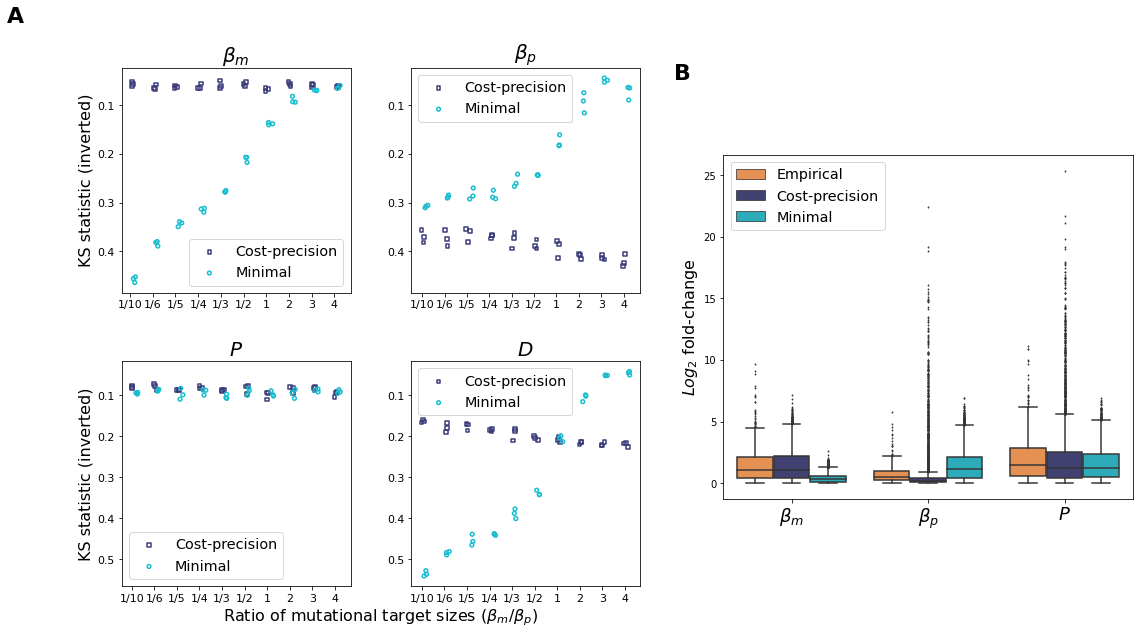

In [13]:
fig = plt.figure(constrained_layout=False, figsize=(16, 8))

# Preparation of the grids
gs1 = fig.add_gridspec(nrows=9, ncols=9, left=0.05, right=0.50, bottom=0.05, 
                       top=0.95, wspace=0.05)
ax1 = fig.add_subplot(gs1[0:4, 0:4])
ax2 = fig.add_subplot(gs1[0:4, 5:9], sharey=ax1)
ax3 = fig.add_subplot(gs1[5:9, 0:4])
ax4 = fig.add_subplot(gs1[5:9, 5:9], sharey=ax3)

gs2 = fig.add_gridspec(nrows=18, ncols=18, left=0.55, right=0.95, bottom=0.05, 
                       top=0.95, wspace=0.05)
ax5 = fig.add_subplot(gs2[3:15, 1:17])

# Parameters for the scatterplots
labels = ['1/10', '1/6', '1/5', '1/4', '1/3', '1/2', '1', '2', '3', '4']

size = 14

palette = {'Cost-precision': cm.tab20b.colors[0], 'Minimal': cm.tab10.colors[9]}
hue_order = ['Cost-precision', 'Minimal']
markers = {'Cost-precision': 's', 'Minimal':'o'}

facecolors = 'none'

linewidths = 1.5

# First scatterplot
scatter1 = hue_scatter('num', 'KS stats', KS_transcription, 'Model', palette, 
                       hue_order, markers, ax1, size=size, 
                       facecolors=facecolors, linewidths=linewidths)

plt.sca(ax1) 
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
ax1.set_xticklabels(['1/10', '1/6', '1/5', '1/4', '1/3', '1/2', '1', '2', '3',
                     '4'])
plt.gca().invert_yaxis() # Invert y-axis for KS stats

ax1.legend(fontsize='x-large')

# Second scatterplot
scatter2 = hue_scatter('num', 'KS stats', KS_translation, 'Model', palette, 
                       hue_order, markers, ax2, size=size, 
                       facecolors=facecolors, linewidths=linewidths)

plt.sca(ax2) 
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
ax2.set_xticklabels(['1/10', '1/6', '1/5', '1/4', '1/3', '1/2', '1', '2', '3',
                     '4'])

ax2.legend(fontsize='x-large')

# Third scatterplot
scatter3 = hue_scatter('num', 'KS stats', KS_prot, 'Model', palette, 
                       hue_order, markers, ax3, size=size, 
                       facecolors=facecolors, linewidths=linewidths)

plt.sca(ax3) 
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
ax3.set_xticklabels(['1/10', '1/6', '1/5', '1/4', '1/3', '1/2', '1', '2', '3',
                     '4'])
plt.gca().invert_yaxis() # Invert y-axis for KS stats

ax3.legend(fontsize='x-large')

# Fourth scatterplot
scatter4 = hue_scatter('num', 'KS stats', KS_ratio, 'Model', palette, 
                       hue_order, markers, ax4, size=size, 
                       facecolors=facecolors, linewidths=linewidths)

plt.sca(ax4) 
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
ax4.set_xticklabels(['1/10', '1/6', '1/5', '1/4', '1/3', '1/2', '1', '2', '3',
                     '4'])

ax4.legend(fontsize='x-large')

# box plot
pal_violin = {'Cost-precision': cm.tab20b.colors[0], 
              'Minimal': cm.tab10.colors[9], 'Empirical': cm.tab20c.colors[5]}
hue_order_emp = ['Empirical', 'Cost-precision', 'Minimal']

sns.boxplot(x='Property', y=r"$Log_2$ fold-change", data=data_melt,
               hue='Data', palette=pal_violin, hue_order=hue_order_emp,
               ax=ax5, fliersize=1)

ax5.legend(fontsize='x-large')

# Axis labels and titles
ax1.set_ylabel('KS statistic (inverted)', fontsize=16)

ax8 = fig.add_subplot(gs1[:, :], frame_on=False)
plt.tick_params(labelcolor="none", bottom=False, left=False)
plt.xlabel(r"Ratio of mutational target sizes ($\beta_m$/$\beta_p$)",
           fontsize=16)

ax3.set_ylabel('KS statistic (inverted)', fontsize=16)

ax5.set_xlabel('')
ax5.set_ylabel(r"$Log_2$ fold-change", fontsize=16)

ax1.set_title(r"$\beta_m$", fontsize=20, fontweight="bold")
ax2.set_title(r"$\beta_p$", fontsize=20, fontweight="bold")
ax3.set_title(r"$P$", fontsize=20, fontweight="bold")
ax4.set_title(r"$D$", fontsize=20, fontweight="bold")

# Set the size of all tick labels
for ax in [ax1, ax2, ax3, ax4]:
  ax.tick_params(labelsize=11)

ax5.tick_params(axis='x', labelsize=18)

# Annotations
ax1.annotate('A', (-0.50, 1.20), xycoords='axes fraction',
             fontsize=22, fontweight="bold", annotation_clip=False)

ax5.annotate('B', (-0.12, 1.22), xycoords='axes fraction',
             fontsize=22, fontweight="bold", annotation_clip=False)

Fig_supp5 = plt.gcf()
Fig_supp5.savefig('/content/drive/My Drive/Redaction_SA/Final_figures/SuppFig5.pdf', bbox_inches='tight')